In [1]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = 'D:/10th Semester/CIFAR-10/train'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 5000/5000 [00:53<00:00, 93.59it/s] 


50000


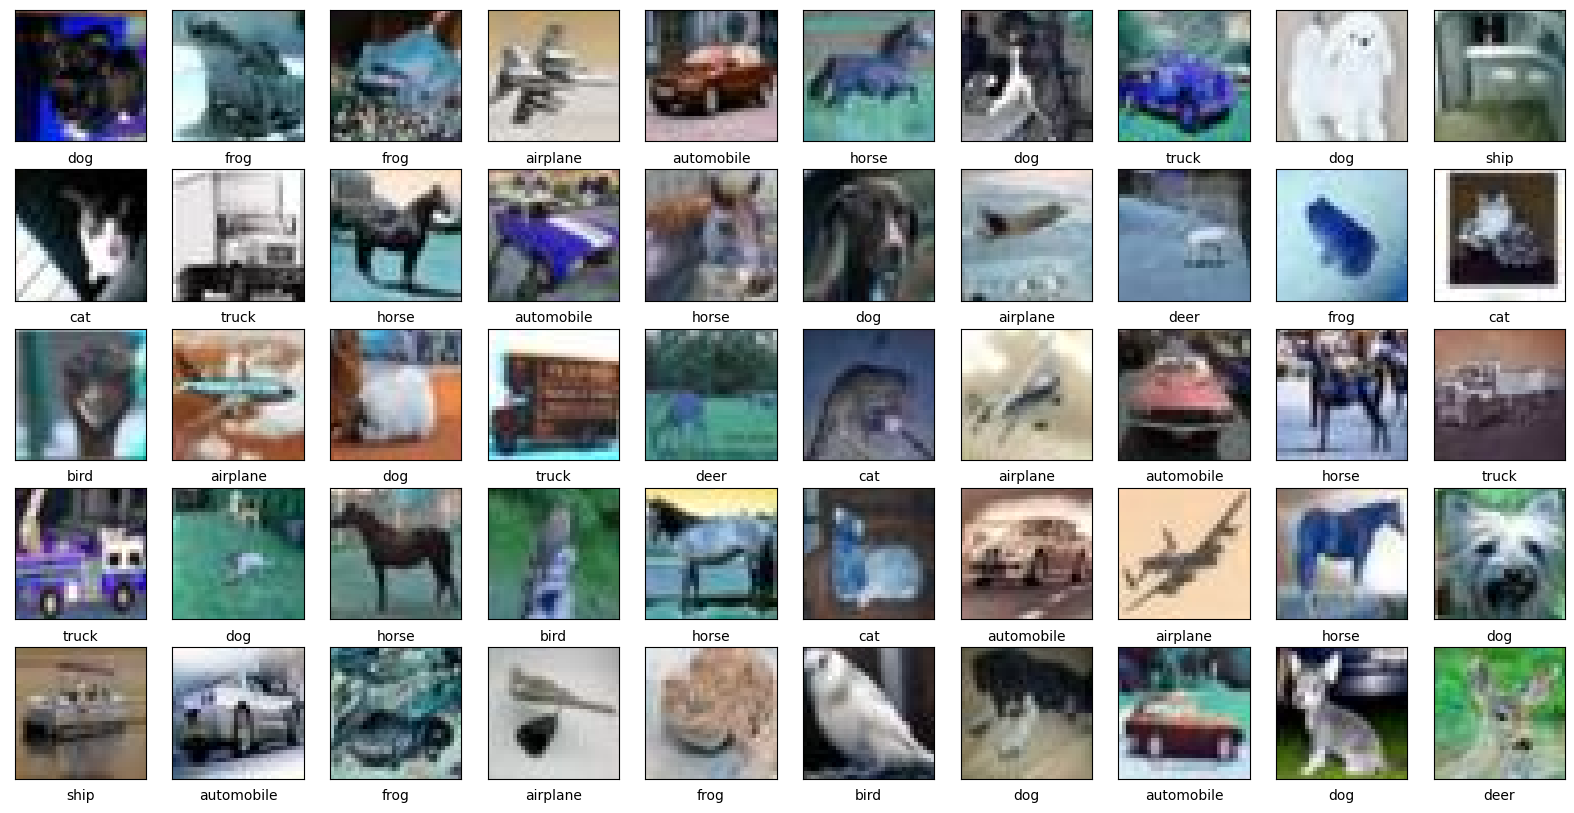

In [4]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(TRAIN_DATA[i][0])
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

In [5]:
f0 = TRAIN_DATA[0:1000]
f1 = TRAIN_DATA[1000:2000]
f2 = TRAIN_DATA[2000:3000]
f3 = TRAIN_DATA[3000:4000]
f4 = TRAIN_DATA[4000:5000]

In [7]:
import numpy as np
import matplotlib.pyplot as plt

k_max = 20

def l1_dist(x, y):
    return np.sum(np.abs(x - y))

def l2_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))



mean_accuracies_l1 = []
std_accuracies_l1 = []
mean_accuracies_l2 = []
std_accuracies_l2 = []

for k in tqdm(range(1, k_max+1,2)):
    fold_accuracies_l1 = []
    fold_accuracies_l2 = []
    
    for i in range(5):
        if i == 0:
            train = f1+f2+f3+f4
            validation = f0
        elif i == 1:
            train = f0+f2+f3+f4
            validation = f1
        elif i == 2:
            train = f1+f0+f3+f4
            validation = f2
        elif i == 3:
            train = f1+f2+f0+f4
            validation = f3
        elif i == 4:
            train = f1+f2+f3+f0
            validation = f4

        acc_l1 = 0
        acc_l2 = 0

        for v in tqdm(validation):
            l1_dists = []
            l2_dists = []
            for t in train:
                l1 = l1_dist(v[0], t[0])
                l2 = l2_dist(v[0], t[0])
                l1_dists.append((l1, t[1]))
                l2_dists.append((l2, t[1]))
            l1_dists.sort(key=lambda x: x[0])
            l2_dists.sort(key=lambda x: x[0])

            neighbors_l1 = [d[1] for d in l1_dists[:k]]
            counts_l1 = np.bincount(neighbors_l1)
            pred_l1 = np.argmax(counts_l1)

            neighbors_l2 = [d[1] for d in l2_dists[:k]]
            counts_l2 = np.bincount(neighbors_l2)
            pred_l2 = np.argmax(counts_l2)

            if pred_l1 == v[1]:
                acc_l1 += 1
            if pred_l2 == v[1]:
                acc_l2 += 1

        fold_accuracies_l1.append(acc_l1 / len(validation))
        fold_accuracies_l2.append(acc_l2 / len(validation))

    mean_accuracies_l1.append(np.mean(fold_accuracies_l1))
    std_accuracies_l1.append(np.std(fold_accuracies_l1))
    mean_accuracies_l2.append(np.mean(fold_accuracies_l2))
    std_accuracies_l2.append(np.std(fold_accuracies_l2))


100%|██████████| 10/10 [4:04:33<00:00, 1467.31s/it]


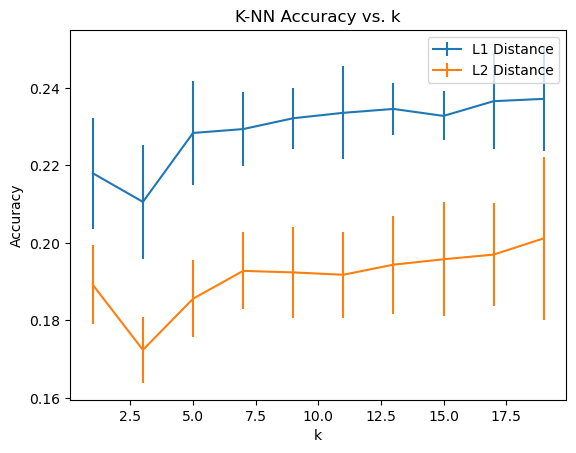

In [8]:
plt.errorbar(range(1, k_max+1,2), mean_accuracies_l1, yerr=std_accuracies_l1, label="L1 Distance")
plt.errorbar(range(1, k_max+1,2), mean_accuracies_l2, yerr=std_accuracies_l2, label="L2 Distance")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("K-NN Accuracy vs. k")
plt.legend()
plt.show()

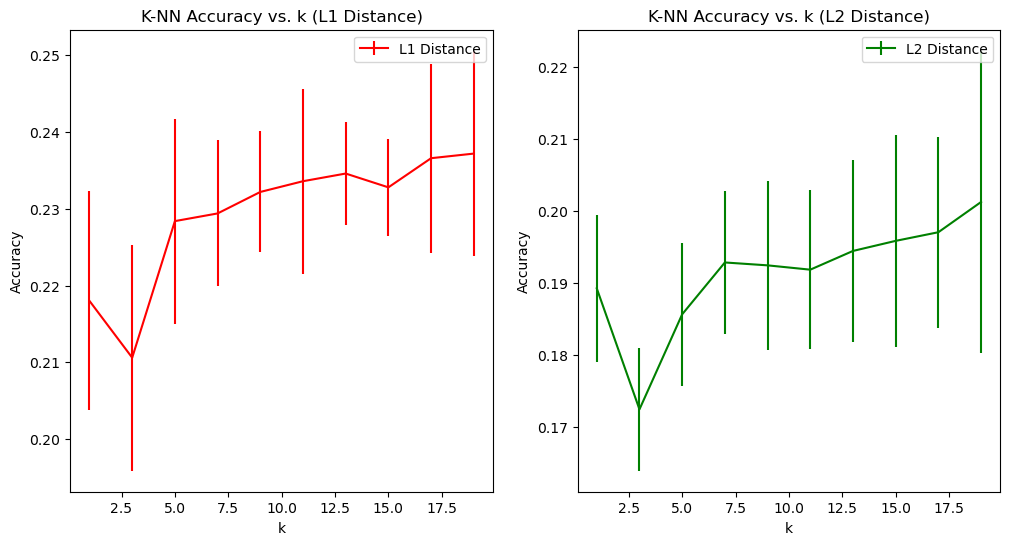

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for L1 distance
ax1.errorbar(range(1, k_max+1,2), mean_accuracies_l1, yerr=std_accuracies_l1, label="L1 Distance", color="red")
ax1.set_xlabel("k")
ax1.set_ylabel("Accuracy")
ax1.set_title("K-NN Accuracy vs. k (L1 Distance)")
ax1.legend()

# Plot for L2 distance
ax2.errorbar(range(1, k_max+1,2), mean_accuracies_l2, yerr=std_accuracies_l2, label="L2 Distance", color="green")
ax2.set_xlabel("k")
ax2.set_ylabel("Accuracy")
ax2.set_title("K-NN Accuracy vs. k (L2 Distance)")
ax2.legend()

plt.show()
